In [72]:
import sys
sys.path.append('../')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from src.segmentation import load_image

In [73]:
model = tf.keras.models.load_model('models/u_net.keras', custom_objects={'mean_iou': tf.keras.metrics.MeanIoU(num_classes=2)})

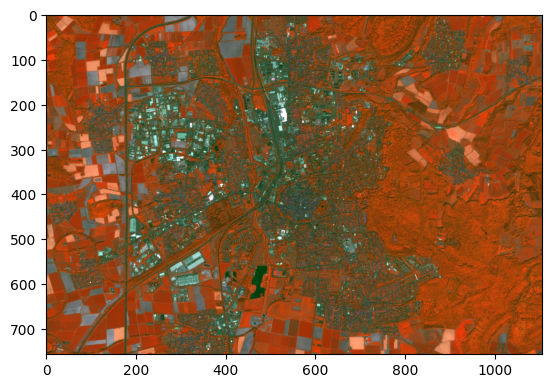

In [44]:
from math import ceil

whole_map = load_image('../data/bronze/whole_city/', 'Goettingen_Sentinel2_20220509.tif')
whole_map = np.array(whole_map)

for axis in range(whole_map.shape[-1]):
    layer = whole_map[..., axis]
    percentile = np.percentile(layer, 99.9)
    layer[layer > percentile] = percentile

    layer = (layer - np.min(layer)) / (np.max(layer) - np.min(layer))
    layer = (layer * 255).astype(np.uint8)

    whole_map[..., axis] = layer

whole_map = whole_map.astype(np.uint8)
whole_map = whole_map[:, :, [3, 1, 2]]

# change the resolution of the image
# DATA:  1 pixel -> 10cm 
# MODEL: 1 pixel -> 20cm
# MAP:   1 pixel -> 10m
# -> 1 pixel in the map is 50 pixels in the model   
# whole_map = Image.fromarray(whole_map)
# whole_map = whole_map.resize((
#     whole_map.size[0] * ceil(50**.5),
#     whole_map.size[1] * ceil(50**.5)
# ), Image.NEAREST)

plt.imshow(whole_map)

(64, 128, 128, 3)
uint8
52 249
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step


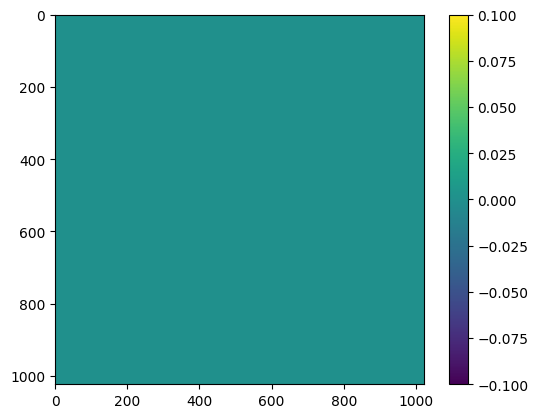

In [71]:
def process_map(whole_map):
    input_map = np.array(whole_map)

    input_map = input_map[
        :(input_map.shape[0] // 128) * 128, 
        :(input_map.shape[1] // 128) * 128
    ]

    batch_map = np.lib.stride_tricks.as_strided(
        input_map,
        shape=(
            input_map.shape[0] // 128,
            input_map.shape[1] // 128,
            128,
            128,
            3
        ),
        strides=(
            input_map.strides[0] * 128,
            input_map.strides[1] * 128,
            input_map.strides[0],
            input_map.strides[1],
            input_map.strides[2]
        )
    ).reshape(
        -1,
        128,
        128,
        3
    )

    print(batch_map.shape)
    print(batch_map.dtype)
    print(batch_map.min(), batch_map.max())

    logits = model.predict(batch_map)
    predictions = tf.sigmoid(logits).numpy()

    # merge the tiles back together
    whole_map_predictions = np.zeros((
        input_map.shape[0],
        input_map.shape[1]
    ))

    for i in range(predictions.shape[0]):
        x = i % (input_map.shape[1] // 128)
        y = i // (input_map.shape[1] // 128)

        whole_map_predictions[
            y * 128:(y + 1) * 128,
            x * 128:(x + 1) * 128
        ] = predictions[i, ..., 0]

    whole_map_predictions = whole_map_predictions
    whole_map_predictions = whole_map_predictions.astype(np.uint8)

    plt.imshow(whole_map_predictions)
    plt.colorbar()

    return whole_map_predictions


import os
dir = '../data/gold/test/tiles/'
files = os.listdir(dir)
for file in files:
    n = 1
    tile = load_image(dir, file)
    tile = tile[::n, ::n]

    out = process_map(tile)

    break

In [60]:
tile